# Project Group 

Members & Student numbers: Willemijn ten Voorden (6101275), Frederiek Backers (4704452), Annerieke Ohm (4852990), Nikolaos Tsironis (6008712)

# Research Objective

*Requires data modeling and quantitative research in Transport, Infrastructure & Logistics*

This research proposal is made for the TIL Programming TIL6022 course project. The focus is on an application project on mobility trends using open-source data, making this a societal project. Inspiration was found in the current discussions on introducing rush hour tax for train tickets in The Netherlands (source: NS wil voorstel spitsheffing beperken tot €2,50 per rit
(https://www.businessinsider.nl/ns-wil-voorstel-spitsheffing-beperken-tot-e250-per-rit-veel-verzet-in-tweede-kamer/)).

This leads to the following research objective: “What are the main attributes of people choosing to travel by train in the Netherlands since 2018?”

Data processing, quantitative analysis and data visualisation will be used to answer this research question.

# Contribution Statement

*Be specific. Some of the tasks can be coding (expect everyone to do this), background research, conceptualisation, visualisation, data analysis, data modelling*

**Author 1**:

**Author 2**:

**Author 3**:

# Data Used

# Data Pipeline

## Import packages

In [1]:
import os
import pandas as pd
%matplotlib inline
import pandas as pd
import numpy as np
import math
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

## Import data

In [2]:
file_path = os.getcwd() + '\Data.csv'

# read data: remove first 6 rows and last row that do not contain data
data = pd.read_csv(file_path, delimiter = ';', skiprows = 6, skipfooter = 1, engine = 'python')

## Data processing

In [3]:
data.set_index('Vervoerwijzen', inplace = True)

# remove rows with missing information
data_updated = data.drop(labels = ["Persoonskenmerken", "Totaal personen", "Leeftijd:6 tot 12 jaar", "Leeftijd: 12 tot 18 jaar", 
                                       "Participatie: werkloos", "Participatie:  arbeidsongeschikt", "Geen rijbewijs; jonger dan 17 jaar", "OV-Studentenkaart: weekendabonnement"])

# replace dots in dataset with 0
data_updated = data_updated.replace('.', 0)



In [4]:
#Only keep columns with "Gemiddeld per persoon per dag | verplaatsingen"
columns_to_keep = [col for col in data_updated.columns if data_updated.loc["Onderwerp", col] == "Gemiddeld per persoon per dag |Verplaatsingen "]
data_updated = data_updated[columns_to_keep]

In [5]:
#Remove the "onderwerp" row, since this is now the same for all columns
data_updated = data_updated.drop("Onderwerp")

In [6]:
# the data is formatted as strings, we convert these to floats and make NaN's equal to 0 for all three dataframes
def preprocess_dataframe(df):
    # Convert strings to floats and replace NaN values with 0
    df = df.apply(lambda col: col.str.replace(',', '.').astype(float).fillna(0))
    return df

data_updated = preprocess_dataframe(data_updated)

In [7]:
#Merge the rows "Leeftijd: 65 tot 75 jaar" en "75jaar of ouder" into one row
data_updated = (data_updated.reset_index()
                .replace({"Vervoerwijzen": {"Leeftijd: 75 jaar of ouder" : "Leeftijd: 65 tot 75 jaar"}})
                .groupby("Vervoerwijzen", sort=False).sum()
)
data_updated = data_updated.rename({"Leeftijd: 65 tot 75 jaar" : "Leeftijd: 65 jaar of ouder"})

In [18]:
#Split dataframe into 5 separate datframes: one for each year and remove row "perioden"
columns_2018 = [col for col in data_updated.columns if int(data_updated.loc["Perioden", col]) == 2018]
columns_2019 = [col for col in data_updated.columns if int(data_updated.loc["Perioden", col]) == 2019]
columns_2020 = [col for col in data_updated.columns if int(data_updated.loc["Perioden", col]) == 2020]
columns_2021 = [col for col in data_updated.columns if int(data_updated.loc["Perioden", col]) == 2021]
columns_2022 = [col for col in data_updated.columns if int(data_updated.loc["Perioden", col]) == 2022]
transport_2018 = data_updated[columns_2018].drop("Perioden")
transport_2019 = data_updated[columns_2019].drop("Perioden")
transport_2020 = data_updated[columns_2020].drop("Perioden")
transport_2021 = data_updated[columns_2021].drop("Perioden")
transport_2022 = data_updated[columns_2022].drop("Perioden")

In [19]:
#Merge car driver and passenger into car, cycle and walk into active modes and trainand bus/tram/metro into public transport
def merge_transport_categories(df):
    #The different years have a number behind the column names. Remove these numbers.
    column_names = ["Total", "Personenauto (bestuurder)", "Personenauto  (passagier)", 
                    "Trein", "Bus/tram/metro", "Fiets", "Lopen", "Overige vervoerwijze"]
    df.columns = column_names
    #Merge desired columns
    df["Passengercar"] = df["Personenauto (bestuurder)"] + df["Personenauto  (passagier)"]
    df["Public Transport"] = df["Trein"] + df["Bus/tram/metro"]
    df["Active modes"] = df["Fiets"] + df["Lopen"]
    df = df.drop(columns = ["Personenauto (bestuurder)", "Personenauto  (passagier)", "Trein", "Bus/tram/metro", "Fiets", "Lopen"])
    #Move "Overige vervoerswijze" to the end of the dataframe
    Other = df.pop("Overige vervoerwijze")
    df["Other modes"] = Other
    #Translate all index names to English
    index_names = ["Age: 18 to 25 years", "Age: 25 to 35 years", "Age: 35 to 50 years", "Age: 50 to 65 years", 
                   "Age: 65 years or older", "Migrationbackground: The Netherlands", "Migrationbackground: Western", 
                   "Migrationbackground: Non-western", "Standardised income: 1st 20str(%) group", "Standardised income: 2nd 20str(%) group",
                   "Standardised income: 3rd 20str(%) group", "Standardised income: 4th 20str(%) group", 
                   "Standardised income: 5th 20str(%) group", "PT-studentcard: Weekday subscription", "PT-studentcard: None",
                   "Education level: Low", "Education level: middle", "Education level: High", "Participation: Working 12 to 30 h/w",
                   "Participation: Working 30+ h/w", "Participation: student", "Participation: retired",
                   "Participation: Other", "Drivers licence; owns own car", "Drivers license; car in household",
                   "Drivers license; no car", "No drivers license"]
    df.index = index_names

    return df

transport_2018 = merge_transport_categories(transport_2018)
transport_2019 = merge_transport_categories(transport_2019)
transport_2020 = merge_transport_categories(transport_2020)
transport_2021 = merge_transport_categories(transport_2021)
transport_2022 = merge_transport_categories(transport_2022)


In [20]:
#Example of what a dataset now looks like. Layout the ame for all years, only numbers might differ.
transport_2018

,Total,Passengercar,Public Transport,Active modes,Other modes
Age: 18 to 25 years,2.74,1.05,0.44,1.12,0.13
Age: 25 to 35 years,2.99,1.52,0.24,1.10,0.12
Age: 35 to 50 years,3.20,1.71,0.13,1.22,0.14
Age: 50 to 65 years,2.80,1.45,0.11,1.12,0.12
Age: 65 years or older,4.05,1.85,0.12,1.94,0.13
Migrationbackground: The Netherlands,2.90,1.38,0.12,1.28,0.12
Migrationbackground: Western,2.57,1.09,0.20,1.21,0.08
Migrationbackground: Non-western,2.22,0.82,0.31,1.03,0.07
Standardised income: 1st 20str(%) group,2.45,0.79,0.22,1.33,0.10
Standardised income: 2nd 20str(%) group,2.46,1.07,0.14,1.16,0.10


## Data analysis

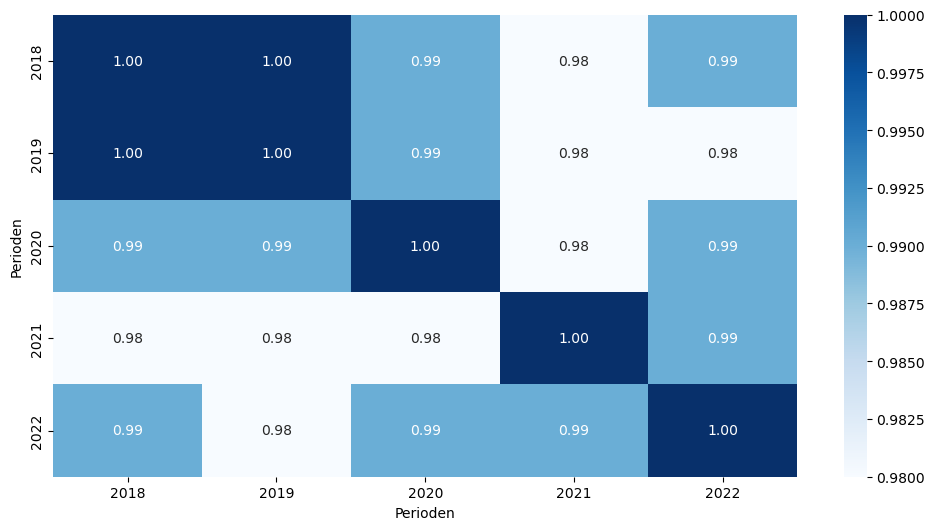